**Aim:** to produce heatmaps that are normalised along one axis. This allows us to show "hotspots" in one variable as a function of another, removing any underlying distribution (modulo statistic fluctuations). This also requires rescaling each bin on the axis so that peak bin contents = 1, otherwise colouring goes askew.

# In ROOT 

In [8]:
import numpy as np

In [1]:
import ROOT

ROOT.gStyle.SetOptStat(0)

Welcome to ROOTaaS 6.06/04


In [2]:
# test data
h = ROOT.TH2D("h", "No normalisation", 25, -2, 2, 25, -2, 2)

In [3]:
# to fill, need to define a function object first
xyg = ROOT.TF2("xyg","xygaus", 0, 10, 0, 10)
xyg.SetParameters(1, 0, 1, 0, 1)  # amplitude, meanx, sigmax, meany, sigmay
h.FillRandom("xyg", 1000000)

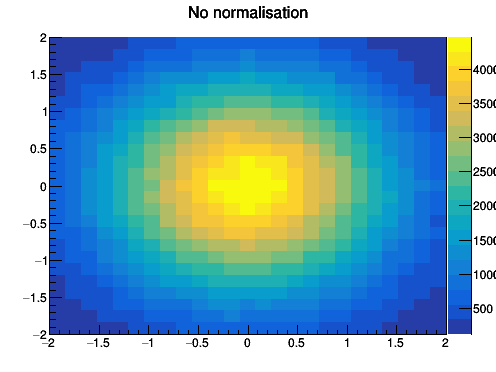

In [4]:
c = ROOT.TCanvas("c", "", 500, 400)
h.Draw("COLZ")
c.Draw()

In [10]:
def th2_to_arr(h):
    """Convert TH2 to 2D numpy array"""
    arr = np.zeros((h.GetNbinsX(), h.GetNbinsY()))
    for x_ind in xrange(1, h.GetNbinsX() + 1):
        for y_ind in xrange(1, h.GetNbinsY() + 1):
            arr[x_ind-1][y_ind-1] = h.GetBinContent(x_ind, y_ind)
    return arr

In [11]:
def make_normalised_TH2(hist, norm_axis):
    if norm_axis not in ['X', 'x', 'y', 'Y']:
        raise RuntimeError("norm_axis must be one of 'X', 'Y' ")
    norm_axis = norm_axis.upper() 
    
    # easiest way to cope with x or y is to just get a 2D matrix of values, 
    # can then do transpose if necessary
    arr = th2_to_arr(hist)

    if norm_axis == 'Y':
        arr = arr.T
    # now set so the maximum in each bin is the same,
    # scale other bins accordingly
    for ind, xbin in enumerate(arr):
        if xbin.max() > 0:
            arr[ind] = xbin / xbin.max()
    if norm_axis == 'Y':
        arr = arr.T

    # Create new hist object - clone to get right bins etc
    new_histname = hist.GetName() + "_norm" + norm_axis
    hnew = hist.Clone(new_histname)
    
    # BUT, hist.Clone() does not update the colorbar
    # So we are forced to create a new hist object?
    # However, this assumes a TH2D object...
#     xaxis = hist.GetXaxis()
#     yaxis = hist.GetYaxis()
#     hnew = ROOT.TH2D(new_histname, hist.GetTitle(), 
#                      hist.GetNbinsX(), xaxis.GetXmin(), xaxis.GetXmax(), 
#                      hist.GetNbinsY(), yaxis.GetXmin(), yaxis.GetXmax())
    for x_ind, x_arr in enumerate(arr, 1):
        for y_ind, val in enumerate(x_arr, 1):
            hnew.SetBinContent(x_ind, y_ind, val)

    return hnew

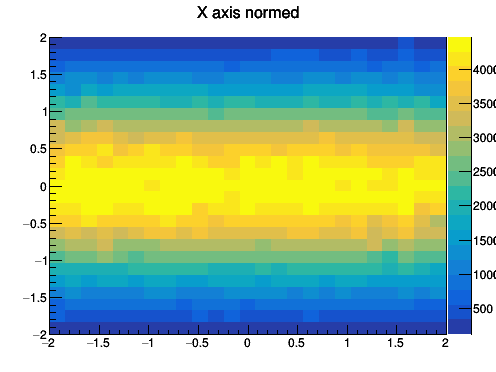

In [20]:
h_new = make_normalised_TH2(h, 'X')
h_new.SetTitle("X axis normed")
h_new.Draw("COLZ")
c.Draw()

So we see it changes the colouring drastically - it now makes it look like Y is peaked symmetrically around 0 for any given X. Which is of course true - it removes **all** information about how X is distributed.

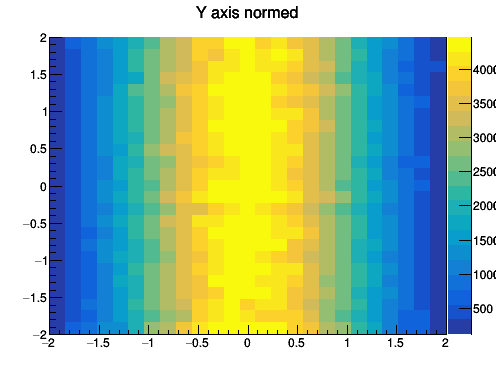

In [21]:
h_new = make_normalised_TH2(h, 'Y')
h_new.SetTitle("Y axis normed")
h_new.Draw("COLZ")
c.Draw()

# In matplotlib 

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

mpl.rcParams['figure.figsize'] = (8.0, 6.0)  # default size of plots - must be called AFTER the %matplotlib inline
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['ytick.minor.size'] = 5


In [15]:
def plot_normed_heatmap(vals_x, vals_y, bins, range, norm_axis, **kwargs):
    
    arr, xedges, yedges = np.histogram2d(vals_x.copy(), vals_y.copy(), bins=bins, range=range)
    # normalise bins along one axis,
    # so that the coloring highlights the "hot spot"
    # in each bin of that axis.
    if norm_axis not in [None, 'X', 'x', 'y', 'Y']:
        raise RuntimeError("norm_axis must be one of None, 'x', 'y' ")
    if norm_axis:
        norm_axis = norm_axis.upper()
        if norm_axis == 'Y':  # transpose trick
            arr = arr.T
        # now set so the maximum in each bin is the same,
        # scale other bins accordingly
        for ind, xbin in enumerate(arr):
            if xbin.max() > 0:
                arr[ind] = xbin / xbin.max()
        if norm_axis == 'Y':
            arr = arr.T

    qm = plt.pcolormesh(xedges, yedges, arr.T, edgecolors='None', **kwargs)
    ax = plt.gca()
    plt.gcf().colorbar(qm, ax=ax, label='p.d.f.')
    plt.minorticks_on()

    return ax, qm, arr



In [16]:
N = int(1E5)
data_x = np.random.normal(size=N)
data_y = np.random.normal(size=N)

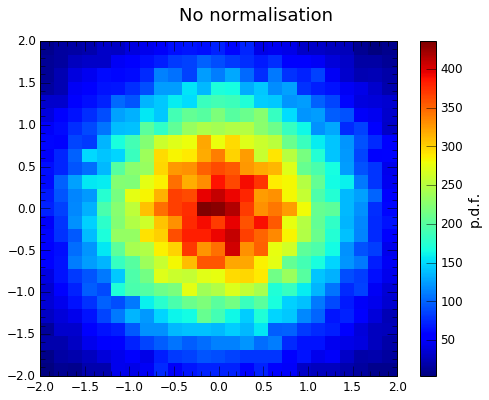

In [17]:
binning = [25, 25]
bin_range = [[-2, 2], [-2, 2]]
_ = plot_normed_heatmap(data_x, data_y, bins=binning, range=bin_range, norm_axis=None)
plt.suptitle('No normalisation')

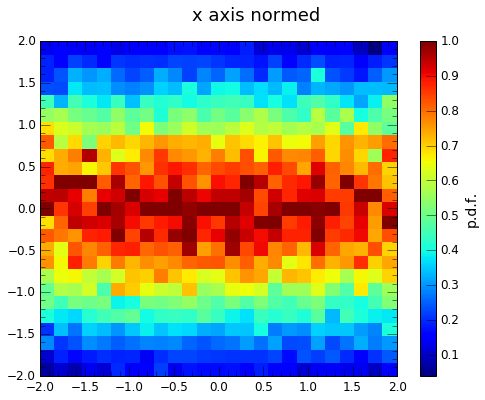

In [18]:
_ = plot_normed_heatmap(data_x, data_y, bins=binning, range=bin_range, norm_axis='x')
plt.suptitle('x axis normed')

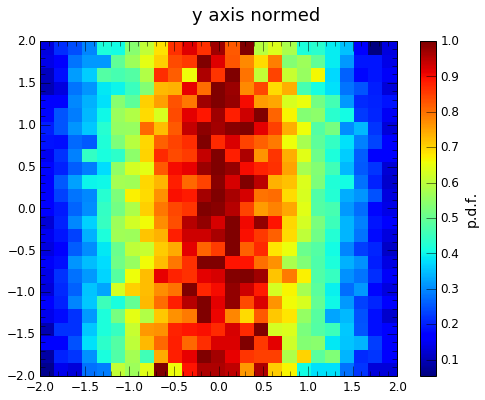

In [19]:
_ = plot_normed_heatmap(data_x, data_y, bins=binning, range=bin_range, norm_axis='y')
plt.suptitle('y axis normed')